# NN Collaborative filter

Collaborative filter:
Movies and customer embeddings.
Replacing the inner product with a concat and a dense NN on top to make a neural collaborative filter.

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import polars as pl
import seaborn as sns

plt.style.use("seaborn-v0_8-whitegrid")

import sys
from pathlib import Path

sys.path.append(str(Path().absolute().parent))

import utilities

### Loading and transforming MovieLens

In [2]:
ratings_df, user_id_mapping, movie_id_mapping = utilities.load_torch_data()
ratings_df

userId,movieId,rating,timestamp,userIdMapped,movieIdMapped
i64,i64,f64,i64,u32,u32
1,5952,4.0,1147868053,0,46
1,296,5.0,1147880044,0,7
2,5952,5.0,1141415528,1,46
2,150,4.0,1141415790,1,5
2,3578,5.0,1141415803,1,42
…,…,…,…,…,…
162541,1136,4.5,1240953505,157480,25
162541,296,3.5,1240953510,157480,7
162541,1197,4.5,1240953534,157480,27


Make into torch datasets

In [3]:
dataloader_train, dataloader_val, dataloader_test = utilities.get_data_loaders(
    ratings_df=ratings_df  # , sample=int(1e5)
)

MLflow logging

In [4]:
from pytorch_lightning.loggers import MLFlowLogger
from datetime import datetime

timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
mlf_logger = MLFlowLogger(
    experiment_name="movie_lens_rating_prediction",
    tracking_uri="mlruns",
    run_name="nn_colab_filter_non_linear_" + timestamp,
)

### Model definition

Fit a model to learn embeddings

In [5]:
import pytorch_lightning as pyl
import torch
import torch.nn as nn
from typing import List


class MovieEmbeddingModel(pyl.LightningModule):
    def __init__(
        self,
        n_users,
        n_movies,
        embedding_dim=10,
        layer_sizes: List[int] = [32, 16],
        learning_rate: float = 5e-3,
    ):
        super().__init__()
        self.user_embedding = nn.Embedding(n_users, embedding_dim)
        self.movie_embedding = nn.Embedding(n_movies, embedding_dim)

        layer_sizes = [embedding_dim * 2] + layer_sizes
        layers = []
        for i in range(len(layer_sizes) - 1):
            layers.append(nn.Linear(layer_sizes[i], layer_sizes[i + 1]))
            layers.append(nn.ReLU())
        self.output = nn.Sequential(*layers, nn.Linear(layer_sizes[-1], 1))

        self.sigmoid = nn.Sigmoid()
        self.max_rating = 5.0
        self.min_rating = 0.5
        self.learning_rate = learning_rate
        self.save_hyperparameters()

    def forward(self, user_ids, movie_ids):
        user_embeds = self.user_embedding(user_ids)
        movie_embeds = self.movie_embedding(movie_ids)
        embeds_concat = torch.concat([user_embeds, movie_embeds], dim=1)
        output = self.output(embeds_concat)
        rating = (
            self.sigmoid(output) * (self.max_rating - self.min_rating) + self.min_rating
        )
        return rating.flatten()

    def training_step(self, batch, batch_idx):
        user_ids, movie_ids, ratings = batch
        predictions = self(user_ids, movie_ids)
        loss = nn.MSELoss()(predictions, ratings)
        self.log("train_loss", loss, on_step=True, on_epoch=True, prog_bar=True)
        return loss

    def validation_step(self, batch, batch_idx):
        user_ids, movie_ids, ratings = batch
        predictions = self(user_ids, movie_ids)
        loss = nn.MSELoss()(predictions, ratings)
        self.log("val_loss", loss, on_step=True, on_epoch=True, prog_bar=True)

    def test_step(self, batch, batch_idx):
        user_ids, movie_ids, ratings = batch
        predictions = self(user_ids, movie_ids)
        loss = nn.MSELoss()(predictions, ratings)
        self.log("test_loss", loss, on_step=True, on_epoch=True, prog_bar=True)

    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters(), lr=self.learning_rate)

Check it works with a small sample

In [6]:
n_users = ratings_df["userIdMapped"].unique().count()
n_movies = ratings_df["movieIdMapped"].unique().count()
batch = next(iter(dataloader_train))
model = MovieEmbeddingModel(n_users, n_movies)
model(batch[0], batch[1])

tensor([2.6811, 2.6657, 2.7416,  ..., 2.7254, 2.6912, 2.7314],
       grad_fn=<ViewBackward0>)

Add early stopping and enforce a minimum of 6 epochs (it takes a few epochs to start improving over a mean baseline)

In [ ]:
from pytorch_lightning.callbacks import Callback, EarlyStopping, ModelCheckpoint

checkpoint_callback = ModelCheckpoint(
    dirpath="checkpoints", save_top_k=1, monitor="val_loss"
)


class EarlyStoppingWithMinEpochs(Callback):
    def __init__(self, min_epochs, **kwargs):
        super().__init__()
        self.min_epochs = min_epochs
        self.early_stopping = EarlyStopping(**kwargs)

    def on_validation_end(self, trainer, pl_module):
        if trainer.current_epoch >= self.min_epochs - 1:
            self.early_stopping.on_validation_end(trainer, pl_module)

    def on_train_end(self, trainer, pl_module):
        self.early_stopping.on_train_end(trainer, pl_module)


early_stop_callback = EarlyStoppingWithMinEpochs(
    min_epochs=6, monitor="val_loss", patience=2, mode="min"
)

Train the model

In [ ]:
model = MovieEmbeddingModel(
    n_users, n_movies, embedding_dim=20, layer_sizes=[16, 16, 16]
)
trainer = pyl.Trainer(
    max_epochs=40,
    logger=mlf_logger,
    log_every_n_steps=1,
    callbacks=[early_stop_callback, checkpoint_callback],
)
trainer.fit(model, dataloader_train, dataloader_val)

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/Users/stantoon/Documents/VariousProjects/github/data-analysis/.venv/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /Users/stantoon/Documents/VariousProjects/github/data-analysis/neural_networks/movie_lens/rating_prediction/checkpoints exists and is not empty.

  | Name            | Type       | Params | Mode 
-------------------------------------------------------
0 | user_embedding  | Embedding  | 3.1 M  | train
1 | movie_embedding | Embedding  | 1.0 K  | train
2 | output          | Sequential | 1.2 K  | train
3 | sigmoid         | Sigmoid    | 0      | train
-------------------------------------------------------
3.2 M     Trainable params
0         Non-trainable params
3.2 M     Total params
12.607    Total estimated model params size (MB)
11        Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/Users/stantoon/Documents/VariousProjects/github/data-analysis/.venv/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:424: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.


/Users/stantoon/Documents/VariousProjects/github/data-analysis/.venv/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:424: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.


Epoch 16:  16%|█▌        | 70/435 [00:09<00:50,  7.22it/s, v_num=a63e, train_loss_step=0.409, val_loss_step=0.715, val_loss_epoch=0.757, train_loss_epoch=0.421] 

Evaluate test set performance

In [ ]:
trainer.test(model, dataloader_test)

/Users/stantoon/Documents/VariousProjects/github/data-analysis/.venv/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:424: The 'test_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.


Testing DataLoader 0: 100%|██████████| 63/63 [00:02<00:00, 22.98it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
     test_loss_epoch        0.7124262452125549
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


[{'test_loss_epoch': 0.7124262452125549}]

Store model

In [ ]:
mlf_logger.experiment.log_artifact(
    mlf_logger.run_id, checkpoint_callback.best_model_path
)

Plotting train/val epoch loss

/var/folders/_v/nlh4h1yx2n1gd6f3szjlgxt40000gr/T/ipykernel_7650/2428333827.py:4: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


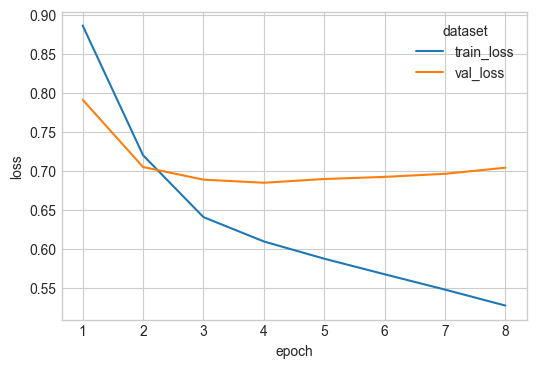

In [ ]:
plot_df = utilities.training_logs_to_df(run_id=mlf_logger.run_id)
fig, ax = plt.subplots(figsize=(6, 4))
sns.lineplot(data=plot_df, x="epoch", y="loss", hue="dataset", ax=ax)
fig.show()

### Check prediction results

We will use a baseline prediction from mean ratings to sanity check

In [ ]:
train_data, val_data, test_data = utilities.split_train_test(ratings_df=ratings_df)
train_data = train_data.with_columns(pl.col("rating").mean().alias("baseline"))

preds = model(
    torch.tensor(train_data["userIdMapped"]), torch.tensor(train_data["movieIdMapped"])
)
train_data = train_data.with_columns(pl.lit(preds.detach().numpy()).alias("nn"))

train_data

userId,movieId,rating,timestamp,userIdMapped,movieIdMapped,baseline,nn
i64,i64,f64,i64,u32,u32,f64,f32
5150,79132,2.5,1459431773,5008,49,3.979833,3.266932
79646,150,3.5,1554224374,77175,5,3.979833,3.868048
63956,318,4.0,948005318,61981,8,3.979833,4.656354
66248,1291,4.5,1189775094,64204,33,3.979833,3.825946
57849,527,4.5,1322993994,56060,16,3.979833,4.048536
…,…,…,…,…,…,…,…
7160,780,3.0,848676694,6942,23,3.979833,3.086337
108304,527,4.0,1419181402,104945,16,3.979833,4.194551
150532,380,3.5,1181551976,145835,13,3.979833,3.051356


We are beating the mean baseline in the training dataset

In [ ]:
print(
    "baseline loss: ",
    nn.MSELoss()(
        torch.tensor(train_data["baseline"]), torch.tensor(train_data["rating"])
    ),
)
print(
    "NN loss: ",
    nn.MSELoss()(torch.tensor(train_data["nn"]), torch.tensor(train_data["rating"])),
)

baseline loss:  tensor(0.9037)
NN loss:  tensor(0.4796)


The histogram of predictions looks reasonable

/var/folders/_v/nlh4h1yx2n1gd6f3szjlgxt40000gr/T/ipykernel_7650/2656779169.py:4: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


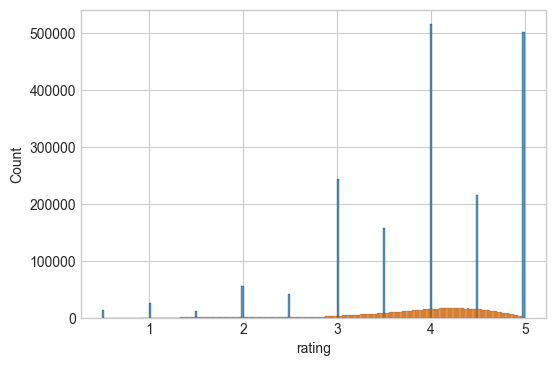

In [ ]:
fig, ax = plt.subplots(figsize=(6, 4))
sns.histplot(data=train_data, x="rating", ax=ax)
sns.histplot(data=train_data, x="nn", ax=ax)
fig.show()